In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '/home/johanna/ICB/annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [2]:
adata = mb.bindome.datasets.scATAC.PBMCs_10x_v2(datadir='../../atac_poisson_study/data/')
peak_ids = adata.var_names

In [4]:
adata

AnnData object with n_obs × n_vars = 10246 × 165434
    var: 'gene_ids', 'feature_types', 'genome', 'chr', 'start', 'end', 'peak.length'

In [5]:
# get sequences

In [3]:
adata.var['summit'] = ((adata.var['end'] + adata.var['start']) / 2).astype(int)
adata.var['summit.start'] = adata.var['summit'] - 100
adata.var['summit.end'] = adata.var['summit'] + 100

In [4]:
adata.var['k.summit'] = adata.var['chr'] + ':' + adata.var['summit.start'].astype(str) + '-' + adata.var['summit.end'].astype(str)

In [5]:
seqs = mb.bindome.tl.get_sequences_from_bed(adata.var[['chr', 'summit.start', 'summit.end']], genome='hg38', uppercase=True)
keys = set([s[0] for s in seqs])
adata = adata[:,adata.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

/tmp/tmpaq0feplo
genome hg38 False
options
/home/johanna/ICB/annotations/hg38/genome/hg38.fa
True /home/johanna/ICB/annotations/hg38/genome/hg38.fa
running bedtools...
bedtools getfasta -fi /home/johanna/ICB/annotations/hg38/genome/hg38.fa -bed /tmp/tmpaq0feplo -fo /tmp/tmp88sb5cx_


In [9]:
adata.shape

(10246, 165376)

In [10]:
seqs[0]

['chr1:10116-10316',
 'CCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAACCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAACCCTAACCCTAAACCCTAAACCCTAACCCTAACCCTAACCCTAACCCTAACCCCAACCCCAACCCCAACCCCAACCCCA']

In [6]:
# remove Ns
seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = adata.X.T

In [7]:
next_data = pd.DataFrame.sparse.from_spmatrix(counts)


In [8]:
next_data['seq'] = [s[1] for s in seqs]

In [14]:
next_data

,0,1,2,3,4,5,6,7,8,9,...,10237,10238,10239,10240,10241,10242,10243,10244,10245,seq
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAACCCTAACCC...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ACAACCCTAACCCTAACCCTAACAACCCTAACCCTAACCCTAACCC...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CGCAGAGAGGCGCGCCGCGCCGGCGCAGGCGCAGAGACACATGCTA...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ACTGGGGCCTGAGCTGCGTGGTGGGGAGAGAGTCTCTCCCCTGCCC...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,CTTCTGAAAGGGTTGCTTGACCCACAGATGTGAAGCTGAGGCTGAA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GACGCCATCCAGAGCTTACAGCTCAGGCCTCCTGCCCTGAGACTAG...
165372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GGGTCCGTGCTGAGGAGAACACTGCTCTGCCTTCCCTGTATCTCCG...
165373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GTGGAGTGGAGTGGAATGGGGGATAATGGAGTGGAGTAGAGTGGAG...
165374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GAATCGAATGGAAGGGAATGAAATTGAATCAACACGAATGGAAGGG...


In [ ]:
next_data[next_data.columns[:-1]].sum(axis=1).sort_values(ascending=False)

In [15]:
# next_data = next_data.head(10000)
next_data = next_data.reindex(next_data[next_data.columns[:-1]].sum(axis=1).sort_values(ascending=False).index).reset_index(drop=True)

In [16]:
next_data

,0,1,2,3,4,5,6,7,8,9,...,10237,10238,10239,10240,10241,10242,10243,10244,10245,seq
0,3.0,4.0,4.0,4.0,3.0,5.0,5.0,7.0,4.0,5.0,...,4.0,2.0,4.0,1.0,4.0,1.0,3.0,4.0,7.0,CCACTTCCAGGACCAACCAATGACTTCAAGGCAGAATATGCCCCCG...
1,5.0,1.0,5.0,8.0,2.0,5.0,6.0,2.0,3.0,3.0,...,2.0,3.0,4.0,1.0,2.0,3.0,5.0,1.0,5.0,TCCAGCGCTCAGGGAGGACGGGAGAATGCGGAATGCCCGGCCAATC...
2,5.0,3.0,3.0,7.0,4.0,2.0,5.0,2.0,1.0,2.0,...,1.0,1.0,7.0,6.0,2.0,0.0,6.0,1.0,2.0,GCACCTGATAGGAACGGCGCTCTAAACCTCCCAAGAATCTCCGCCT...
3,1.0,1.0,4.0,5.0,1.0,7.0,7.0,5.0,2.0,7.0,...,3.0,2.0,2.0,1.0,3.0,7.0,4.0,3.0,0.0,CTGGGGGGAAGGGCGGAGCCAATCCGACGTAACCCAATCCAAGATT...
4,3.0,1.0,6.0,5.0,4.0,1.0,9.0,1.0,3.0,5.0,...,4.0,1.0,3.0,0.0,6.0,1.0,2.0,2.0,1.0,GCCCCCGCGTTACCGTCCCGCCCGCAGGACGCATCTCCAACGCCTC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GATCTTTGTCACTGCAGGGCTGTTGCCAAGATTAGAAAGAATGCAT...
165372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCAGAGAGGACGGTAAAGGGAGCCAGGCCCACAGGCACCGAGAGAC...
165373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GTAGAATTCACCAGTGAATCAATATGATCCTGGGCTTTTCTTTGTT...
165374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CTGGGCAGCATAGCAAGGTCTCATCTCTTAAAAAAATGGAGACAAT...


In [9]:
next_data_sel = next_data[[i for i in range(15)] + ['seq']]
next_data_sel = next_data_sel[next_data_sel[next_data_sel.columns[:-1]].sum(axis=1) > 10]
next_data_sel = next_data_sel[next_data_sel['seq'].str.len() == 200].reset_index(drop=True)
next_data_sel

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,seq
0,0.0,0.0,2.0,1.0,2.0,4.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,AACACCCGCGCCTCTAACGTCGCCAACGGCCCACCTCTATGGTGTC...
1,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,TTTTGTTTCTTCCGCTCACTCTGGGGCATGCCTCGGGAAAGGGAAA...
2,0.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,GCCGCTCCACTCTGGGTCCCCCCGCCCTGCCCTGCTATAGCCCCAC...
3,0.0,3.0,0.0,4.0,3.0,1.0,5.0,0.0,1.0,2.0,1.0,0.0,2.0,3.0,0.0,CGCCCCGGCCCCGGCGCCAGGCCCCGCAGCTCCCAAAGAAAACTAC...
4,1.0,3.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,GCGAACGGGCGCGACCTCACGGAGGGGACGCCGGCGCCACCATCTC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,1.0,0.0,1.0,0.0,2.0,2.0,4.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,CTGACTCACTGGGGCCCATCGGGAGATGCCGGGGTGGCAGCAGGAG...
5660,1.0,3.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,GGCGCGAGAAGCCGGGGGGGCGGTGCTGCAGCCTCGGCGAGGGGAC...
5661,1.0,3.0,1.0,3.0,1.0,2.0,2.0,0.0,0.0,4.0,1.0,2.0,0.0,2.0,0.0,GCTCCCACCGCGAGACCTTCTGCTCCGCGCCCGCGCGGGCCCCTCC...
5662,0.0,0.0,4.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,CATCCTGGGTCCCACCCCGGGGGCGCCCCGGGCGCGGAGGGGGCGT...


In [10]:
next_data_sel.to_csv('next_data_sel.csv')

In [8]:
next_data_sel = pd.read_csv('next_data_sel.csv', index_col=0)
next_data_sel.columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'seq']

In [19]:
next_data_sel = next_data_sel[next_data_sel[next_data_sel.columns[:-1]].sum(axis=1) > 10]
next_data_sel

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,seq
0,3.0,4.0,4.0,4.0,3.0,5.0,5.0,7.0,4.0,5.0,3.0,5.0,3.0,2.0,2.0,CCACTTCCAGGACCAACCAATGACTTCAAGGCAGAATATGCCCCCG...
1,5.0,1.0,5.0,8.0,2.0,5.0,6.0,2.0,3.0,3.0,0.0,3.0,2.0,6.0,2.0,TCCAGCGCTCAGGGAGGACGGGAGAATGCGGAATGCCCGGCCAATC...
2,5.0,3.0,3.0,7.0,4.0,2.0,5.0,2.0,1.0,2.0,9.0,1.0,3.0,2.0,1.0,GCACCTGATAGGAACGGCGCTCTAAACCTCCCAAGAATCTCCGCCT...
3,1.0,1.0,4.0,5.0,1.0,7.0,7.0,5.0,2.0,7.0,3.0,1.0,2.0,3.0,1.0,CTGGGGGGAAGGGCGGAGCCAATCCGACGTAACCCAATCCAAGATT...
4,3.0,1.0,6.0,5.0,4.0,1.0,9.0,1.0,3.0,5.0,2.0,1.0,2.0,1.0,1.0,GCCCCCGCGTTACCGTCCCGCCCGCAGGACGCATCTCCAACGCCTC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17341,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,3.0,AGTACTGTCTGTGCTTCGCTCTCTCCCCCAGCTGAGTTCCTTTCTG...
20967,0.0,0.0,0.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,CCACTGCGGGGCGTGGCTGCCGGCAAAGGATGGAGTTCGGGCGGGC...
21249,1.0,0.0,1.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,3.0,ACCACGCGTGGGAGGAAACCCAGGACGGGCGCCTGAGCCTCGGTGG...
21787,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,4.0,1.0,0.0,0.0,0.0,AGCACACAGCAGCTGCTCAACAGATATTTCCTGAACAAGCAAAAAA...


In [21]:
next_data_sel = next_data_sel[next_data_sel['seq'].str.len() == 200].reset_index(drop=True)

In [22]:
next_data_sel.sum(axis=1)

0       59.0
1       53.0
2       50.0
3       50.0
4       45.0
        ... 
5659    11.0
5660    11.0
5661    13.0
5662    12.0
5663    11.0
Length: 5664, dtype: float64

In [6]:
n_rounds = next_data_sel.shape[1] - 2
n_rounds

14

In [9]:
next_data_sel

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,seq
0,0.0,0.0,2.0,1.0,2.0,4.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,AACACCCGCGCCTCTAACGTCGCCAACGGCCCACCTCTATGGTGTC...
1,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,TTTTGTTTCTTCCGCTCACTCTGGGGCATGCCTCGGGAAAGGGAAA...
2,0.0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,GCCGCTCCACTCTGGGTCCCCCCGCCCTGCCCTGCTATAGCCCCAC...
3,0.0,3.0,0.0,4.0,3.0,1.0,5.0,0.0,1.0,2.0,1.0,0.0,2.0,3.0,0.0,CGCCCCGGCCCCGGCGCCAGGCCCCGCAGCTCCCAAAGAAAACTAC...
4,1.0,3.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,GCGAACGGGCGCGACCTCACGGAGGGGACGCCGGCGCCACCATCTC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,1.0,0.0,1.0,0.0,2.0,2.0,4.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,CTGACTCACTGGGGCCCATCGGGAGATGCCGGGGTGGCAGCAGGAG...
5660,1.0,3.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,GGCGCGAGAAGCCGGGGGGGCGGTGCTGCAGCCTCGGCGAGGGGAC...
5661,1.0,3.0,1.0,3.0,1.0,2.0,2.0,0.0,0.0,4.0,1.0,2.0,0.0,2.0,0.0,GCTCCCACCGCGAGACCTTCTGCTCCGCGCCCGCGCGGGCCCCTCC...
5662,0.0,0.0,4.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,CATCCTGGGTCCCACCCCGGGGGCGCCCCGGGCGCGGAGGGGGCGT...


In [10]:
dataset = mb.datasets.SelexDataset(next_data_sel, n_rounds=n_rounds)
train = tdata.DataLoader(dataset=dataset, batch_size=100, shuffle=True)
train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)

In [11]:
w = 12
n_kernels = 3

In [25]:
model = mb.models.DinucSelex(use_dinuc=False, kernels=[0] + [w] * (n_kernels - 1),  n_rounds=n_rounds, enr_series=False).to(device)

In [13]:
for ki in range(n_kernels):
    mb.tl.update_grad(model, ki, ki == 0)

In [26]:
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()

In [27]:
mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=500, early_stopping=5, log_each=1)

Epoch:  1, Loss: 0.863
Epoch:  2, Loss: 0.850
Epoch:  3, Loss: 0.850
Epoch:  4, Loss: 0.851
Epoch:  5, Loss: 0.850
Epoch:  6, Loss: 0.850
Epoch:  7, Loss: 0.850
Epoch:  8, Loss: 0.851
Epoch:  9, Loss: 0.850
Epoch: 10, Loss: 0.850
Epoch: 11, Loss: 0.851
Epoch: 12, Loss: 0.850
Epoch: 13, Loss: 0.850
Epoch: 14, Loss: 0.850


[0.8629431659457905,
 0.8504609386091269,
 0.8504603164244088,
 0.8505044528454309,
 0.8503734983503669,
 0.8504299248615111,
 0.85043944464697,
 0.8507630431712403,
 0.8503307742942893,
 0.8503973050543948,
 0.8505832253603197,
 0.8504957558565954,
 0.8503982868019315,
 0.8504712993541884]

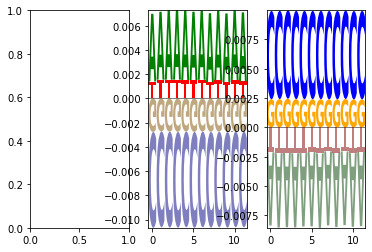

In [28]:
mb.pl.conv_mono(model)

In [16]:
all_targets, all_outputs = [], []
for i, batch in enumerate(train_test):
    # Get a batch and potentially send it to GPU memory.
    # print(batch.keys())
    # mononuc = batch["mononuc"].type(torch.LongTensor).to(device)
    mononuc = batch['mononuc'].to(device)
    mononuc_rev = batch['mononuc_rev'].to(device) if 'mononuc_rev' in batch else None
    dinuc = batch['dinuc'].type(torch.LongTensor).to(device) if 'dinuc' in batch else None
    dinuc_rev = batch['dinuc_rev'].to(device) if 'dinuc_rev' in batch else None
    b = batch['batch'].to(device) if 'batch' in batch else None
    target = batch['target'].to(device) if 'target' in batch else None
    rounds = batch['rounds'].to(device) if 'rounds' in batch else None
    is_count_data = batch['is_count_data'] if 'is_count_data' in batch else None
    seqlen = batch['seqlen'] if 'seqlen' in batch else None
    countsum = batch['countsum'].to(device) if 'countsum' in batch else None

    inputs = (mononuc, b, seqlen, countsum)
    outputs = model(inputs)  # Forward pass through the network.
    all_targets.append(rounds.squeeze().cpu().detach().numpy())
    all_outputs.append(outputs.squeeze().cpu().detach().numpy())
    if i >= 200:
        break

In [17]:
all_outputs

[array([0.70848499, 0.43885727, 0.909325  , 1.03001234, 0.63257539,
        0.99885446, 1.70296866, 0.7424874 , 0.67626312, 0.81562293,
        0.80457839, 0.71758926, 0.5483344 , 0.76622754, 0.5078183 ]),
 array([0.64944454, 0.40228583, 0.833548  , 0.94417798, 0.57986074,
        0.9156165 , 1.56105477, 0.68061349, 0.61990795, 0.74765443,
        0.73753019, 0.65779024, 0.50263987, 0.70237533, 0.46550015]),
 array([0.64944454, 0.40228579, 0.833548  , 0.94417798, 0.57986069,
        0.9156165 , 1.56105477, 0.68061349, 0.61990795, 0.74765443,
        0.73753011, 0.6577902 , 0.50263987, 0.70237533, 0.46550015]),
 array([1.47601031, 0.91428598, 1.89442728, 2.14585885, 1.31786531,
        2.08094697, 3.54785137, 1.54684884, 1.4088816 , 1.69921443,
        1.67620499, 1.49497753, 1.14236344, 1.59630757, 1.05795478]),
 array([0.88560635, 0.54857165, 1.13665648, 1.28751576, 0.79071935,
        1.24856785, 2.12871127, 0.92810942, 0.84532913, 1.01952888,
        1.00572299, 0.89698685, 0.685418

In [ ]:
next_data_sel = next_data[[i for i in range(15)] + ['seq']]
next_data_sel = next_data_sel[next_data_sel[next_data_sel.columns[:-1]].sum(axis=1) > 10]
next_data_sel.shape
# for testing purposes
# next_data['seq'] = next_data['seq'].astype(str).str[:min(next_data['seq'].str.len())]
next_data_sel = next_data_sel[next_data_sel['seq'].str.len() == 200].reset_index(drop=True)
next_data_sel.sum(axis=1)
n_rounds = next_data_sel.shape[1] - 2
n_rounds
# # n_rounds
dataset = mb.datasets.SelexDataset(next_data_sel, n_rounds=n_rounds)
train = tdata.DataLoader(dataset=dataset, batch_size=100, shuffle=True)
# s = [mb.tl.onehot_mononuc(row['seq'], le, oe) for index, row in next_data.iterrows()]
# model = mb.models.DinucSelex(use_dinuc=True, kernels=[0] + [w] * (n_kernels - 1),  n_rounds=n_rounds).to(device)


import copy
model_by_k = {}
optimize_motif_shift = True
n_kernels = 3
num_epochs = 500
early_stopping = 5
log_each = 25
seqlen = list(next_data['seq'].str.len())[0]

for w in range(12, seqlen, 2):
    # step 1) freeze everything before the current binding mode
    print('next seqlen', w)
    model = mb.models.DinucSelex(use_dinuc=True, kernels=[0] + [w] * (n_kernels - 1),  n_rounds=n_rounds, enr_series=False).to(device)

    for i in range(0, n_kernels):
        print('kernel to optimize %i' % i)

        for ki in range(n_kernels):
            mb.tl.update_grad(model, ki, ki == i)

        optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
        criterion = mb.tl.PoissonLoss()
        mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=num_epochs,
                            early_stopping=early_stopping, log_each=log_each)
        model.load_state_dict(model.best_model_state) # probably here load the state of the best epoch and save 
        k_parms = 'model_%i' % w
        model_by_k[k_parms] = copy.deepcopy(model) # store model parameters and fit for later visualization
        # optimizer for left / right flanks
        best_loss = model_by_k[k_parms].best_loss

        print('before shift optim.')
        mb.pl.conv_mono(model)

        #######
        # optimize the flanks through +1/-1 shifts
        #######
        if optimize_motif_shift and i != 0:
            next_loss = None
            while next_loss is None or next_loss < best_loss:
                print('optimize_motif_shift (%s)...' % ('once' if next_loss is None else 'again'), end='')
                model = model_by_k[k_parms]
                best_loss = model.best_loss

                model_left = mb.tl.train_shift(copy.deepcopy(model), train, kernel_i=i, shift=1,
                                               device=device, num_epochs=num_epochs,
                                               early_stopping=early_stopping, log_each=log_each,
                                               update_grad_i=i)
                model_right = mb.tl.train_shift(copy.deepcopy(model), train, kernel_i=i, shift=-1,
                                                device=device, num_epochs=num_epochs,
                                                early_stopping=early_stopping, log_each=log_each,
                                                update_grad_i=i)
                print(best_loss, model_left.best_loss, model_right.best_loss)
                best = sorted([[model, best_loss],
                               [model_left, model_left.best_loss],
                               [model_right, model_right.best_loss]], key= lambda x: x[-1])
                next_model, next_loss = best[0]
                model_by_k[k_parms] = copy.deepcopy(next_model)

        model = model_by_k[k_parms]
        n_feat = sum([np.prod(layer.kernel_size) for conv in [model.conv_mono, model.conv_di] for layer in conv if layer is not None])
        l_best = model.best_loss

        print('after shift optimz model')
        mb.pl.conv_mono(model_by_k[k_parms])
        print('')

    assert False

    r = [k_parms, w, n_feat, l_best]
    # print(r)
    res.append(r)
    print('')

In [ ]:
from matplotlib import rcParams

In [ ]:
next_data_sel

In [ ]:
import seaborn as sns
rcParams['figure.figsize'] = 5, 3

activity = np.exp(model.log_activity.weight.cpu().detach().numpy())
rel_activity = activity / np.sum(activity)
sns.heatmap(rel_activity.T, cmap='Reds')
plt.title('rel contrib.')
plt.ylabel('selection round')
plt.xlabel('binding mode rel activity')
